In [15]:
from modules.models.embedders.latent_embedders import VAE

latent_embedder = VAE
latent_embedder_checkpoint = './runs/first_stage-2023_08_11_230709 (best AE so far + mask)/last.ckpt'


vae = latent_embedder.load_from_checkpoint(latent_embedder_checkpoint, time_embedder=None)
vae = vae.to('cpu')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch
from modules.models.embedders.latent_embedders import VAE

model_3d = VAE(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 1,
    spatial_dims    = 3, # 2D or 3D
    hid_chs         = [32, 64, 128, 256], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none', # ['none', 'none', 'none', 'spatial'],
    loss            = torch.nn.MSELoss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5}
)

model_2d = VAE(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 1,
    spatial_dims    = 2, # 2D or 3D
    hid_chs         = [32, 64, 128, 256], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none', # ['none', 'none', 'none', 'spatial'],
    loss            = torch.nn.MSELoss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5}
)

model_3d = model_3d.to('cuda')
model_2d = model_2d.to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


In [11]:
import time
from tqdm import tqdm

start = time.time()

for _ in tqdm(range(1000)):
    x = torch.randn(1, 1, 128, 128, 64).to('cuda')
    x_hat, _, _ = model_3d(x)

end = time.time()

t_3d = (end - start) / 100

start = time.time()

for _ in tqdm(range(1000)):
    x = torch.randn(64, 1, 128, 128).to('cuda')
    x_hat, _, _ = model_2d(x)

end = time.time()

t_2d = (end - start) / 100

print('3D: {}s'.format(t_3d))
print('2D: {}s'.format(t_2d))

100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]

3D: 0.6204198908805847s
2D: 0.47316832780838014s


In [12]:
print('3D: {}s'.format(t_3d))
print('2D: {}s'.format(t_2d))
print('Ratio: {}'.format(t_3d / t_2d))

3D: 0.6204198908805847s
2D: 0.47316832780838014s
Ratio: 1.3112033380472525


In [19]:
import torch
from modules.models.pipelines import DiffusionPipeline
from modules.models.estimators import UNet
from modules.models.noise_schedulers import GaussianNoiseScheduler
from modules.models.embedders import TimeEmbbeding
from modules.models.embedders.latent_embedders import VAE

latent_embedder = VAE(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 1,
    spatial_dims    = 2, # 2D or 3D
    hid_chs         = [32, 64, 128, 256], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none', # ['none', 'none', 'none', 'spatial'],
    loss            = torch.nn.MSELoss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5}
).to('cuda')

cond_embedder = None 
# cond_embedder = LabelEmbedder
cond_embedder_kwargs = {
    'emb_dim': 1024,
    'num_classes': 2
}


time_embedder = TimeEmbbeding
time_embedder_kwargs ={
    'emb_dim': 1024 # stable diffusion uses 4*model_channels (model_channels is about 256)
}

noise_scheduler = GaussianNoiseScheduler
noise_scheduler_kwargs = {
    'timesteps': 1000,
    'beta_start': 0.002, # 0.0001, 0.0015
    'beta_end': 0.02, # 0.01, 0.0195
    'schedule_strategy': 'cosine'
}

noise_estimator = UNet
noise_estimator_kwargs = {
    'in_ch': 1, 
    'out_ch': 1, 
    'spatial_dims': 2,
    'hid_chs':  [256, 256, 512, 1024],
    'kernel_sizes':[3, 3, 3, 3],
    'strides':     [1, 2, 2, 2],
    'time_embedder':time_embedder,
    'time_embedder_kwargs': time_embedder_kwargs,
    'cond_embedder':cond_embedder,
    'cond_embedder_kwargs': cond_embedder_kwargs,
    'deep_supervision': False,
    'use_res_block':True,
    'use_attention':'none',
}

pipeline = DiffusionPipeline(
    noise_estimator=noise_estimator, 
    noise_estimator_kwargs=noise_estimator_kwargs,
    noise_scheduler=noise_scheduler, 
    noise_scheduler_kwargs = noise_scheduler_kwargs,
    latent_embedder=latent_embedder,
    # latent_embedder_checkpoint = latent_embedder_checkpoint,
    estimator_objective='x_T',
    estimate_variance=False, 
    use_self_conditioning=False, 
    use_ema=False,
    classifier_free_guidance_dropout=0.0, # Disable during training by setting to 0
    do_input_centering=False,
    clip_x0=False
).to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


In [21]:
import time

start = time.time()

for _ in range(10):
    sample_img = pipeline.sample(num_samples=1, img_size=(1, 128, 128), condition=None, steps=50, use_ddim=True).detach()

end = time.time()

t_3d = (end - start) / 10
print('3D: {}s'.format(t_3d))

50it [00:01, 27.68it/s]
50it [00:01, 27.83it/s]
50it [00:01, 27.66it/s]
50it [00:01, 27.71it/s]
50it [00:01, 27.72it/s]
50it [00:01, 27.85it/s]
50it [00:01, 27.64it/s]
50it [00:01, 27.46it/s]
50it [00:01, 27.48it/s]
50it [00:01, 27.55it/s]

3D: 1.8144766807556152s


In [50]:
latent_embedder = VAE
latent_embedder_checkpoint = './runs/first_stage-2023_08_11_230709 (best AE so far + mask)/epoch=489-step=807030.ckpt'

latent_embedder = latent_embedder.load_from_checkpoint(latent_embedder_checkpoint, time_embedder=None)

pipeline = DiffusionPipeline.load_from_checkpoint(
    './runs/2023_08_16_113818 (continuity)/epoch=999-step=63000.ckpt', 
    latent_embedder=latent_embedder.to('cuda'),
).to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'latent_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['latent_embedder'])`.
  rank_zero_warn(


300it [00:11, 26.05it/s]


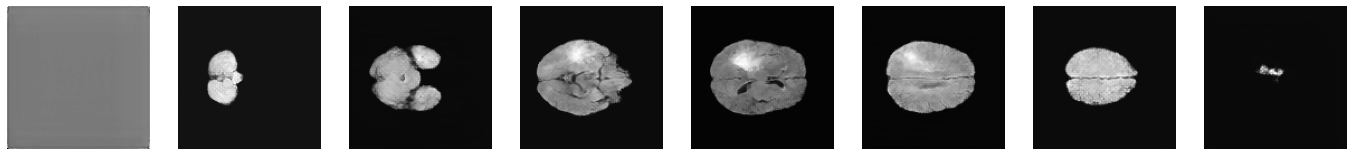

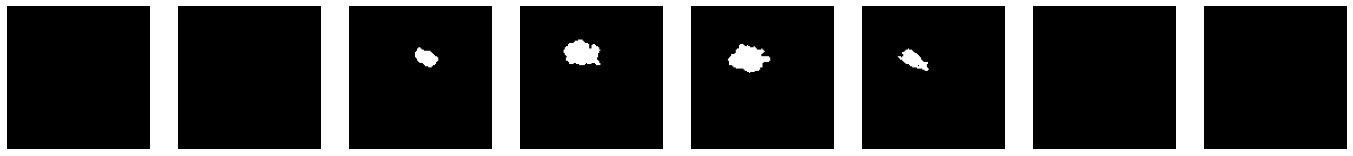

In [65]:
import matplotlib.pyplot as plt
import numpy as np

img = pipeline.sample(num_samples=1, img_size=(8, 128, 128), condition=None, use_ddim=True, steps=300).detach()
img = img.reshape(1, 8, 64, 16, 16).squeeze(0).permute(1, 0, 2, 3)
decoded_slices = latent_embedder.decode(img, emb=None).detach()

decoded_slices[:, 1] = decoded_slices[:, 1].clip_(-1, 1).add_(1).mul_(0.5).round_()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 0, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 1, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

## --------------------------------------------------------

In [2]:
import torch
from modules.data import BRATSDataModule


dm = BRATSDataModule(
    data_dir        = './data/brats_preprocessed.npy',
    train_ratio     = 0.95,
    norm            = 'centered-norm',
    batch_size      = 8,
    num_workers     = 6,
    shuffle         = True,
    horizontal_flip = 0.5,
    vertical_flip   = 0.5,
    slice_wise      = False,
    drop_channels   = [0]
)

In [3]:
dm.setup()
loader = dm.train_dataloader()

Normalizing data: 100%|██████████| 1000/1000 [00:01<00:00, 864.73it/s]



        DataModule setup complete.
        Number of training samples: 950
        Number of validation samples: 50
        Data shape: torch.Size([1000, 1, 128, 128, 64])
        Maximum: 1.0, Minimum: -1.0
        


In [ ]:
import torch.nn as nn

class MaskReconstructionLoss(nn.Module):
    def __init__(self, alpha_dice=1.0, alpha_mse=1.0, alpha_acc=1.0):
        """
        Custom loss function for binary masks with spatial consistency loss.

        Args:
        - alpha_dice (float): Weight for Dice loss.
        - alpha_mse (float): Weight for MSE loss.
        - alpha_acc (float): Weight for accuracy loss.
        """
        super(MaskReconstructionLoss, self).__init__()
        self.alpha_dice = alpha_dice
        self.alpha_mse = alpha_mse
        self.alpha_acc = alpha_acc

    def forward(self, mask_pred, mask_target):
        """
        Forward pass of the custom loss.

        Args:
        - mask_pred (torch.Tensor): Predicted masks of shape (batch_size, 1, 128, 128, 64).
        - mask_target (torch.Tensor): Target masks of the same shape as mask_pred.

        Returns:
        - loss (torch.Tensor): Combined loss.
        """
        dims = (1, 2, 3) + ((4,) if mask_pred.dim() == 5 else ())

        # Dice Loss
        dice_loss = 1 - (2 * (mask_pred * mask_target).sum(dim=dims) + 1) / (mask_pred.sum(dim=dims) + mask_target.sum(dim=dims) + 1)

        # MSE Loss
        mse_loss = nn.functional.mse_loss(mask_pred, mask_target, reduction='none').mean(dim=dims)

        # Accuracy Loss
        acc_loss = (mask_pred == mask_target).float().mean(dim=dims)

        # Combine the losses with the specified weights
        loss = (self.alpha_dice * dice_loss) + (self.alpha_mse * mse_loss) + (self.alpha_acc * acc_loss)

        return loss
    
m = MaskReconstructionLoss(alpha_dice=0.0, alpha_mse=1.0, alpha_acc=0.0)

mask_pred = torch.bernoulli(torch.empty(8, 1, 128, 128, 64).fill_(0.3)).float()
mask_target = torch.bernoulli(torch.empty(8, 1, 128, 128, 64).fill_(0.7)).float()

m(mask_pred, mask_target)


In [4]:
from modules.models.embedders.latent_embedders import VAE

vae = VAE.load_from_checkpoint('./runs/mask-embedder-2023_09_05_161605-VAgTys/last.ckpt')
vae = vae.to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
batch = next(iter(loader))

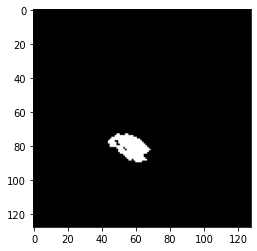

In [15]:
plt.imshow(batch[0][0, 0, :, :, 40].cpu().detach(), cmap='gray')

In [7]:
o = vae(batch[0].to('cuda'))

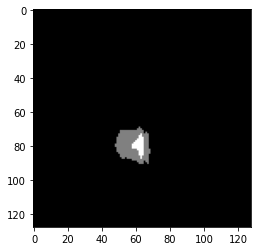

In [16]:
import matplotlib.pyplot as plt

plt.imshow(o[0][0, 0, :, :, 40].cpu().detach().round(), cmap='gray')

50it [00:01, 25.99it/s]


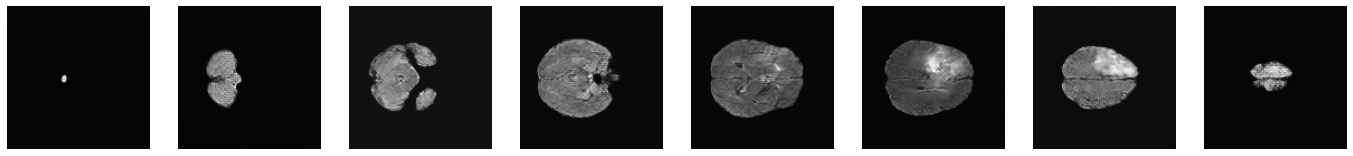

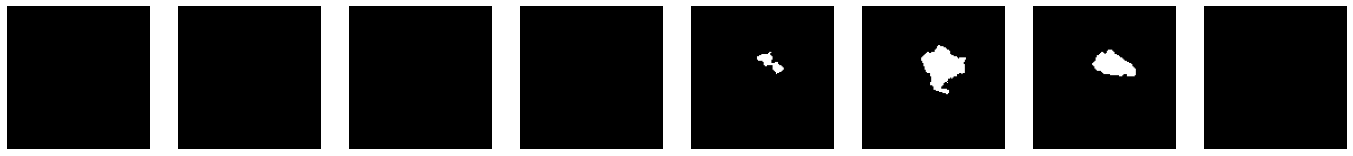

In [77]:
import matplotlib.pyplot as plt
import numpy as np

img = pipeline.sample(num_samples=1, img_size=(8, 128, 128), condition=None, use_ddim=True, steps=50).detach()
img = img.reshape(1, 8, 64, 16, 16).squeeze(0).permute(1, 0, 2, 3)
decoded_slices = latent_embedder.decode(img, emb=None).detach()

decoded_slices[:, 1] = decoded_slices[:, 1].clip_(-1, 1).add_(1).mul_(0.5).round_()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 0, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 1, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
import time

start = time.time()

for _ in range(10):
    sample_img = pipeline.sample(num_samples=1, img_size=(1, 64, 16, 16), condition=None).detach()

end = time.time()

t_3d = (end - start) / 10
print('3D: {}s'.format(t_3d))

In [65]:
import torch
import torch.nn.functional as F

def spatially_stack_latents(latents, grid_size, index_channel=False):
    batch_size, num_latents, num_channels, height, width = latents.size()
    latents_stacked = latents.permute(0, 2, 1, 3, 4).contiguous()  # Rearrange dimensions
    
    grid_height = grid_size[0]
    grid_width = grid_size[1]
    
    num_cols = num_latents // grid_height
    num_rows = num_latents // grid_width
    
    assert num_cols * num_rows == num_latents, "Grid size is not compatible with number of latents"

    latents_stacked = latents_stacked.view(batch_size, num_channels, num_rows, num_cols, height, width)
    latents_stacked = latents_stacked.permute(0, 1, 2, 4, 3, 5).contiguous()  # Rearrange dimensions
    latents_stacked = latents_stacked.view(batch_size, num_channels, num_rows * height, num_cols * width)

    if index_channel:
        # generating an index channel
        index_channel = torch.ones(batch_size, 1, num_rows * height, num_cols * width)
        for i in range(num_rows):
            for j in range(num_cols):
                index_channel[:, :, i * height : (i + 1) * height, j * width : (j + 1) * width] *= (i * num_cols + j)
        
        # Add index channel
        latents_stacked = torch.cat([latents_stacked, index_channel.to(latents_stacked.device)], dim=1)
    
    return latents_stacked

def reverse_spatial_stack(latents_stacked, shape, index_channel=False):
    if index_channel: # we drop the index channel
        latents_stacked = latents_stacked[:, :-1, ...]

    batch_size, num_channels, height, width = latents_stacked.size()
    orig_height, orig_width = shape
    num_cols = width // orig_width
    num_rows = height // orig_height

    latents_stacked = latents_stacked.reshape(batch_size, num_channels, num_rows, orig_height, num_cols, orig_width)
    latents_stacked = latents_stacked.permute(0, 1, 2, 4, 3, 5).contiguous()  # Rearrange dimensions
    latents_stacked = latents_stacked.reshape(batch_size, num_channels, num_rows * num_cols, orig_height, orig_width)
    
    # channels first
    latents_stacked = latents_stacked.permute(0, 2, 1, 3, 4).contiguous()  # Rearrange dimensions

    return latents_stacked

# Example usage
batch_size = 1
num_latents = 9
num_channels = 1
height = 2
width = 2
latents = torch.ones(batch_size, num_latents, num_channels, height, width)
for idx in range(num_latents):
    latents[:, idx, :, :, :] *= idx

grid_size = (3, 3)  # Grid of 4x16 latents
latents_stacked = spatially_stack_latents(latents, grid_size, index_channel=True)
reconstructed_latents = reverse_spatial_stack(latents_stacked, shape=(2, 2), index_channel=True)

print("Original Latents Shape:", latents.shape)
print("Stacked Latents Shape:", latents_stacked.shape) 
print("Reconstructed Latents Shape:", reconstructed_latents.shape)

Original Latents Shape: torch.Size([1, 9, 1, 2, 2])
Stacked Latents Shape: torch.Size([1, 2, 6, 6])
Reconstructed Latents Shape: torch.Size([1, 9, 1, 2, 2])


In [1]:
import torch
x = torch.randn(4, 2, 128, 128)
x_hat = torch.randn(4, 2, 128, 128)

originals = torch.cat([
    torch.hstack([img for img in x[:, idx, ...]])
    for idx in range(x.shape[1])
], dim=0)

reconstructed = torch.cat([
    torch.hstack([img for img in x_hat[:, idx, ...]])
    for idx in range(x_hat.shape[1])
], dim=0)

img = torch.cat([originals, reconstructed], dim=0)
img.shape

torch.Size([512, 512])

In [1]:
import numpy as np

data = np.load('./data/brats_preprocessed.npy')

In [35]:
import torch

x = torch.randint(0, 2, size=(4, 4))

x

tensor([[0, 1, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 0, 1],
        [1, 1, 1, 1]])

In [5]:
from modules.models.embedders.latent_embedders import VAEGAN
import torch

model = VAEGAN(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 2,
    spatial_dims    = 2,
    hid_chs         = [64, 128, 256, 512],
    deep_supervision = False,
    use_attention   = ['none', 'none', 'none', 'spatial'],
    start_gan_train_step = -1,
    embedding_loss_weight = 1e-6,
)

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
o = model(torch.randn(4, 1, 128, 128))
o[1]

[]

In [2]:
import numpy as np
data = np.load('./brats_preprocessed.npy', allow_pickle=True)
data = data[:, 0, None]
data = data.transpose(0, 4, 1, 2, 3) # depth first

norm = lambda data: (2 * data - data.min() - data.max()) / (data.max() - data.min())
for idx in range(data.shape[0]):
    data[idx] = norm(data[idx]).astype(np.float32)

data = data.reshape(-1, 1, 128, 128)

print(data.shape)
print(data.max(), data.min())

(64000, 1, 128, 128)
1.0 -1.0


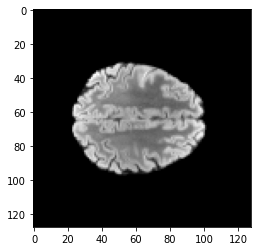

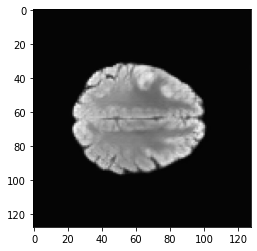

In [31]:
import matplotlib.pyplot as plt

idx = 300

# original
plt.imshow(data[idx, 0, :, :], cmap='gray')
plt.show()

import torch

x = torch.from_numpy(data[idx, None, :, :, :]).to('cuda', torch.float32)
recon, _, _ = vae(x)
plt.imshow(recon[0, 0].detach().cpu().numpy(), cmap='gray')

In [2]:
import torch
import numpy as np

from medical_diffusion.models.embedders.latent_embedders import VAE
from medical_diffusion.data.datamodules import SimpleDataModule

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]

: 

: 

In [1]:
import pytorch_lightning.utilities.cloud_io as plcloud

In [10]:
data = np.load('./brats_preprocessed.npy', allow_pickle=True)
data = data[:, 0, None, ..., 32]

norm = lambda data: (2 * data - data.min() - data.max()) / (data.max() - data.min())
for idx in range(data.shape[0]):
    data[idx] = norm(data[idx]).astype(np.float32)

dataset = IdentityDataset(data)

dm = SimpleDataModule(
    ds_train = dataset,
    batch_size=8, 
    num_workers=0,
    pin_memory=False
) 

In [17]:
import pytorch_lightning as pl

In [11]:
dm.prepare_data()
dm.setup(stage='train')

In [12]:
loader = dm.train_dataloader()

In [13]:
b = next(iter(loader))

\begin{table}[t]
\footnotesize
\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{@{}clccccc@{}}
\toprule
\multicolumn{2}{c}{\multirow{2}{*}{Methods}} & \multicolumn{5}{c}{Number of training volumes} \\ \cmidrule(l){3-7} 
                         &                         & 10 & 20 & 30 & 40 & 50 \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(l){7-7}
\multirow{3}{*}{BRATS}   & Reference               & 0.604$\pm$0.07 & 0.620$\pm$0.06 & 0.663$\pm$0.04 & 0.672$\pm$0.05 & 0.703$\pm$0.01 \\
                         & Ours ($\alpha = 0.01$)  & 0.790$\pm$0.01 & 0.818$\pm$0.01 & 0.842$\pm$0.01 & 0.808$\pm$0.02 & 0.821$\pm$0.01 \\ 
                         & Ours + Aug. ($\times$5) & \textbf{0.799$\pm$0.02} & \textbf{0.828$\pm$0.01} & \textbf{0.845$\pm$0.01} & \textbf{0.822$\pm$0.03} & \textbf{0.840$\pm$0.03} \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(l){7-7}
\multirow{3}{*}{HECKTOR} & Reference               & 0.454$\pm$0.11  & 0.528$\pm$0.10  & 0.542$\pm$0.02  & 0.629$\pm$0.04  & 0.648$\pm$0.04  \\
                         & Ours ($\alpha = 0.01$)  & 0.596$\pm$0.04  & 0.622$\pm$0.04  & 0.672$\pm$0.01  & 0.679$\pm$0.01  & 0.688$\pm$0.03  \\
                         & Ours + Aug. ($\times$5) & \textbf{0.668$\pm$0.01}  & \textbf{0.627$\pm$0.03}  & \textbf{0.680$\pm$0.01} & \textbf{0.684$\pm$0.01} & \textbf{0.696$\pm$0.01}  \\ \bottomrule
\end{tabular}%
}
\caption{Quantitative performance of the our approach evaluated in terms of DSC (\%↑)  with respect to the base number of real volumes used for training. We also present an augmented variant of our approach in conjunction with standard augmentation methods, resulting in additional performance enhancement. \label{tab:volumes}}
\end{table}

\begin{table}[h]
\centering
\resizebox{8cm}{!}{
\begin{tabular}{@{}cccc@{}}
\toprule
\multicolumn{2}{c}{Methods}                                    & BRATS & HECKTOR \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multicolumn{2}{c}{Reference}                                  & 0.663$\pm$0.04 & 0542$\pm$0.02       \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multicolumn{2}{c}{Augmented ($\times$2)}                      & 0.786$\pm$0.01              & 0.563$\pm$0.04        \\
\multicolumn{2}{c}{Augmented ($\times$3)}                      & 0.798$\pm$0.01              & 0.587$\pm$0.13      \\
\multicolumn{2}{c}{Augmented ($\times$5)}                      & 0.810$\pm$0.01              & 0.658$\pm$0.14  \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{LSGAN}                  & + 500 synthetic  & 0.703$\pm$0.03 & 0.609$\pm$0.11 \\
                                        & + 1000 synthetic & 0.720$\pm$0.04 & 0.622$\pm$0.03 \\
                                        & + 1500 synthetic & 0.697$\pm$0.03 & 0.617$\pm$0.03 \\
                                        & + 2000 synthetic & 0.676$\pm$0.06 & 0570$\pm$0.02  \\
                                        \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{VAE}                    & + 500 synthetic  & 0.740$\pm$0.08 & 0.584$\pm$0.02 \\
                                        & + 1000 synthetic & 0.773$\pm$0.04 & 0.595$\pm$0.02 \\
                                        & + 1500 synthetic & 0.752$\pm$0.03 & 0.570$\pm$0.02 \\
                                        & + 2000 synthetic & 0.704$\pm$0.06 & 0.563$\pm$0.10 \\ 
                                        \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{HVAE}                   & + 500 synthetic  & 0.749$\pm$0.06 & 0.586$\pm$0.01 \\
                                        & + 1000 synthetic & 0.760$\pm$0.07 & 0.614$\pm$0.04 \\
                                        & + 1500 synthetic & 0.778$\pm$0.02 & 0.592$\pm$0.03 \\
                                        & + 2000 synthetic & 0.763$\pm$0.05 & 0.599$\pm$0.10 \\ 
                                        \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{Ours ($\alpha = 0.01$)} & + 500 synthetic  & 0.763$\pm$0.04 & 0.670$\pm$0.02 \\
                                        & + 1000 synthetic & 0.789$\pm$0.02 & \textbf{0.672$\pm$0.01} \\
                                        & + 1500 synthetic & 0.816$\pm$0.04 & 0.637$\pm$0.01 \\
                                        & + 2000 synthetic & \textbf{0.844$\pm$0.01} & 0.607$\pm$0.03 \\ 
                                        \bottomrule
\end{tabular}%
}
\caption{Quantitative performance of the generative models is evaluated in terms of DSC (\%↑) on BRATS and HECKTOR. \label{tab:dice}}
\end{table}
